In [1]:
!pip install ultralytics --quiet

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image
import zipfile
from IPython.display import FileLink
from tqdm import tqdm
from pathlib import Path
from ultralytics import YOLO, SAM
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
def zip_dir(directory = os.curdir, file_name = 'segmented.zip'):
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

def get_images_from_videos(IN_PATH, OUT_PATH):
    if not os.path.exists(OUT_PATH):
        os.makedirs(OUT_PATH)
        
    for video in tqdm(os.listdir(IN_PATH)):
        vid = os.path.join(IN_PATH, video)
        vidName = str(video.split(".")[0])
        cap = cv2.VideoCapture(vid)
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_interval = max(1, total_frames // 30)  # Ensure at least one frame is extracted

        count = 0
        success = True
        while success:
            success, image = cap.read()
            if count % frame_interval == 0:
                img_filename = f'{OUT_PATH}/{vidName}_{count}.jpg'
                if success:
                    cv2.imwrite(img_filename, image)
            count += 1

        cap.release()
        
def plot_bbox(img, bbox_list):
    for bbox in bbox_list:
        x, y, w, h = bbox
        # Convert normalized coordinates to pixel values
        img_height, img_width, _ = img.shape
        x, y, w, h = int(x), int(y), int(w), int(h)
        # Calculate the top-left and bottom-right coordinates of the bounding box
        x1, y1 = x - w // 2, y - h // 2
        x2, y2 = x + w // 2, y + h // 2
        # Draw the bounding box on the image
        color = (0, 255, 0)  # Green color
        thickness = 2
        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    return img

def annotate(data, det_model="yolov8x.pt", sam_model="sam_l.pt", device="", output_dir=None):
    det_model = YOLO(det_model, verbose=False)
    sam_model = SAM(sam_model)

    data = Path(data)
    if not output_dir:
        output_dir = data.parent / f"{data.stem}_auto_annotate_labels"
    Path(output_dir).mkdir(exist_ok=True, parents=True)

    det_results = det_model(data, stream=True, device=device, verbose=False)

    for result in tqdm(det_results):
        class_ids = result.boxes.cls.int().tolist()  # noqa
        if len(class_ids):
            boxes = result.boxes.xyxy  # Boxes object for bbox outputs
            sam_results = sam_model(result.orig_img, bboxes=boxes, verbose=False, save=False, device=device)
            segments = sam_results[0].masks.xyn  # noqa

            with open(f"{Path(output_dir) / Path(result.path).stem}.txt", "w") as f:
                s = segments[0]
                if len(s) == 0:
                    continue
                segment = map(str, segments[0].reshape(-1).tolist())
                f.write(f"{1} " + " ".join(segment) + "\n")

In [4]:
sam = SAM('sam_l.pt')
det_model = YOLO('/kaggle/input/segment/best.pt')

100%|██████████| 1.16G/1.16G [00:04<00:00, 308MB/s] 


In [27]:
IN_PATH = '//kaggle/input/segment/Shoes Dataset/Shoes Dataset'
OUT_PATH = '/kaggle/working/Segmented'
get_images_from_videos(IN_PATH, OUT_PATH)

100%|██████████| 101/101 [13:54<00:00,  8.27s/it]


In [30]:
len(os.listdir('/kaggle/working/Segmented'))

3151

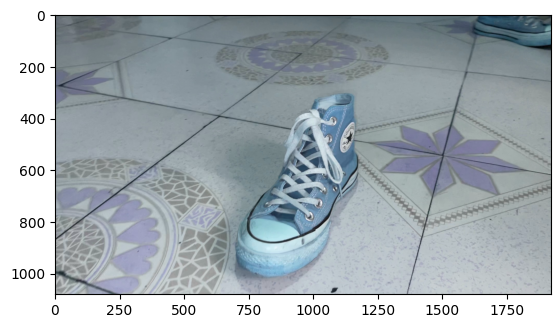

In [31]:
plt.imshow(cv2.imread('/kaggle/working/Segmented/IMG_1214_216.jpg'))

In [32]:
annotate('/kaggle/working/Segmented',\
         det_model="/kaggle/input/segment/best.pt",\
         sam_model="sam_l.pt", device=DEVICE)

3151it [57:46,  1.10s/it]


In [33]:
!rm -rf /kaggle/working/sam_l.pt

In [34]:
zip_dir('/kaggle/working/')

/kaggle/working/segmented.zip

In [25]:
os.getcwd()

'/kaggle/working/coco/segmented'

**Experiments**

In [23]:
# Give the path of your image
IMAGE_PATH= '/kaggle/input/segment/shoes.jpg'
image = process_image(IMAGE_PATH, resize_factor=2)

input_box = model(image)[0].boxes.xyxy[0].cpu().numpy()
mask_predictor.set_image(image)
# input_point = np.array([[x, y]])
# input_label = np.array([1])


# Predict the segmentation mask at that point
masks, scores, logits = mask_predictor.predict(
# point_coords=input_point,
# point_labels=input_label,
box=input_box,
multimask_output=False,
)

print(masks)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


In [24]:
#convert to coco format
binary_mask = masks.squeeze().astype(np.uint8)
contours, hierarchy = cv2.findContours(binary_mask,
                                    cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)


largest_contour = max(contours, key=cv2.contourArea)
segmentation = largest_contour.flatten().tolist()

In [26]:
int(cv2.contourArea(largest_contour))

596113

In [28]:
largest_contour.shape

(1650, 1, 2)

In [35]:
annotations = [{
    'id': 1,
    'image_id': 1,
    'category_id': 1,
    'segmentation': [segmentation],
    'area': int(cv2.contourArea(largest_contour[0])),
    'iscrowd': 0
}]

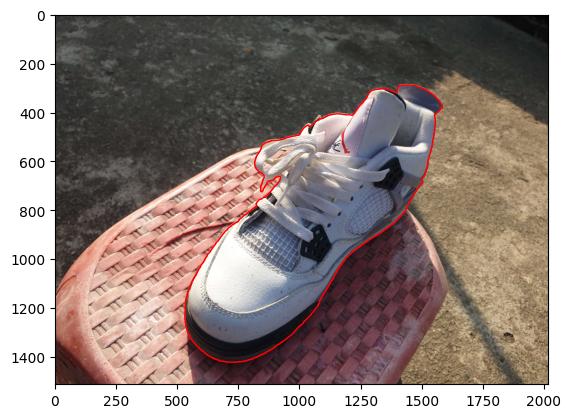

In [44]:
#plot coco format annotations
# Load image using PIL or any other image library
image_path = '/kaggle/input/segment/shoes.jpg'
image = Image.open(image_path)
image = image.resize((2016, 1512))
# Create figure and axes
fig, ax = plt.subplots(1)
ax.imshow(np.array(image))

# Plot segmentation masks
for annotation in annotations:
    segmentation = annotation['segmentation'][0]
    segmentation = np.array(segmentation).reshape((len(segmentation)//2, 2))
    polygon = Polygon(segmentation, closed=True, edgecolor='r', facecolor='none')
    ax.add_patch(polygon)

plt.show()